In [1]:
!pip install datasets
!pip install sentence_transformers
!pip install --upgrade transformers
!pip install pandas
!pip install torchmetrics --upgrade
!pip install nbformat
!pip install git+https://github.com/openai/CLIP.git
!pip install bert_score
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 6.4 MB/s

In [5]:

from PIL import Image
import torch
import os
from datasets import load_dataset
from datasets.utils.file_utils import get_datasets_user_agent
import requests
import numpy as np
import pandas as pd
import json
import clip
# from natsort import natsorted
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from sentence_transformers import SentenceTransformer, util
from torchmetrics.multimodal.clip_score import CLIPScore
USER_AGENT = get_datasets_user_agent()
from bert_score import score
from diffusers import StableDiffusionPipeline
from tqdm import tqdm



/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_no

In [6]:



def calculate_clip_score(image, correct_prompt, revers_prompt, model, preprocess, device):
    try:
        # Ensure image is preprocessed and on the right device
        image_input = preprocess(image).unsqueeze(0).to(device)

        # Encode image features
        with torch.no_grad():
            image_features = model.encode_image(image_input)

            # Encode text prompts
            text_tokens = clip.tokenize([correct_prompt, revers_prompt]).to(device)
            text_features = model.encode_text(text_tokens)

            # Normalize the features
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            # Calculate cosine similarities
            correct_score = torch.cosine_similarity(image_features, text_features[0].unsqueeze(0)).item()
            reverse_score = torch.cosine_similarity(image_features, text_features[1].unsqueeze(0)).item()

        # Clear GPU memory if using GPU
        if torch.cuda.is_available() and device == 'cuda':
            torch.cuda.empty_cache()

        return correct_score * 100, reverse_score * 100

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None  # Return default values or handle the error appropriately


In [7]:
def calculate_blip_2(image, prompt, processor ,model, device):
    try:
        img_inputs = processor(images=image, return_tensors="pt").to(device)
        if next(model.parameters()).device != device:
            model.to(device)
        # Generate image features
        with torch.no_grad():
          generated_ids = model.generate(**img_inputs)

        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        # generated_text_embedding = similarity_model.encode(generated_text)
        # caption_embedding = similarity_model.encode(prompt)
        # Compute BERTScore for semantic similarity
        P, R, F1 = score(generated_text, prompt, lang="en", rescale_with_baseline=True)

        return F1, generated_text
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    finally:
        # Clear GPU memory if using GPU
        if torch.cuda.is_available() and device == 'cuda':
            torch.cuda.empty_cache()

In [8]:

def csv_to_json (csv_file_path , json_file_path):
    df = pd.read_csv(csv_file_path)
    df.to_json(json_file_path, orient='records', lines=True)
    print(f"CSV file has been converted to JSON and saved at {json_file_path}")
    return json_file_path

In [9]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns


def evaluation(save_dir, json_file , metric= "clip", img_col = 'file_name', text_col='text', revers_col = "reverse_text", output_file_name = 'output'):
    # Open the file in write mode ('w')
    print_data=[]
    total_blip_score =[]
    total_reverse_blip_score =[]
    total_diff_blip =[]
    blip_count =0
    total_clip_score =[]
    total_reverse_clip_score =[]
    total_diff_clip =[]
    clip_count =0
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)  # Load the entire JSON data
    # Iterate over each entry in the array
    for entry in data:
        img_path = os.path.join(save_dir, entry[img_col])
        caption = entry[text_col]
        revers_caption = entry[revers_col]
        if img_path.endswith(".jpg") or img_path.endswith(".png"):
            img = Image.open(img_path)
        if(metric in ("clip", "both")):
            device = "cuda" if torch.cuda.is_available() else "cpu"
            model, preprocess = clip.load("ViT-B/32", device=device)
            print(f"Metric used is CLIP Score using {device}")
            print_data.append(f"Metric used is CLIP Score using {device}")
            score , reverse_score= calculate_clip_score(img, caption, revers_caption, model, preprocess, device )
            diff = (score - reverse_score)
            print(f"Image: {img_path}, Caption: {caption}, CLIP Score: {score}, reverse caption {revers_caption}, reverse score {reverse_score}, diff*10 {diff*10}")
            print_data.append(f"Image: {img_path}, Caption: {caption}, CLIP Score: {score}, reverse caption {revers_caption}, reverse score {reverse_score}, diff*10 {diff*10}")
            total_clip_score.append(score)
            total_reverse_clip_score.append(reverse_score)
            total_diff_clip.append(10*diff)
            clip_count += 1
        if(metric in ("blip" , "both")):
            print(f"Metric used is BLIP Score")
            print_data.append(f"Metric used is BLIP Score")
            processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl")
            model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-flan-t5-xl")
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            print(f"Using {device}")
            blip_score, generated_caption = calculate_blip_2(img,caption,processor,model,device)
            blip_reverse_score, reverse_generated_caption = calculate_blip_2(img,revers_caption,processor,model,device)
            blip_diff = blip_score - blip_reverse_score
            total_blip_score.append(blip_score)
            total_reverse_blip_score.append(blip_reverse_score)
            total_diff_blip.append(blip_diff)
            blip_count += 1
            print(f"Image: {img_path}, Caption: {caption}, Generated Caption {generated_caption} BLIP2 Score: {blip_score}, reverse caption: {revers_caption} , reverse BLIP score {blip_reverse_score} ")
            print_data.append(f"Image: {img_path}, Caption: {caption}, Generated Caption {generated_caption} BLIP2 Score: {blip_score}, reverse caption: {revers_caption} , reverse BLIP score {blip_reverse_score} ")
        # Calculate averages
    if clip_count > 0:
        avg_clip_score = np.mean(total_clip_score)
        avg_reverse_clip_score = np.mean(total_reverse_clip_score)
        avg_diff_clip = np.mean(total_diff_clip)
        # Calculate variance
        var_clip_score= np.var(total_clip_score)
        var_reverse_clip_score = np.var(total_reverse_clip_score)
        var_diff_clip = np.var(total_diff_clip)
        # Create the box plot
        all_clip_scores = [total_clip_score, total_reverse_clip_score, total_diff_clip]
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=all_clip_scores)
        plt.xticks(ticks=range(len(all_clip_scores)), labels=['CLIP Score', 'Reverse CLIP Score', 'CLIP Diffx10'])
        plt.ylabel('Score')
        plt.title('Distribution of Image-Caption Pair Scores')
        plt.grid(True)
        plt.savefig(f'{save_dir}/clip_distribution.png')  # You can change the file format by changing the extension
        plt.show()
        plt.close()  # Close the plot to free up memory
        print(f"CLIP Score: Avrage:{avg_clip_score} var: {var_clip_score},  Reverse CLIP Score: avg:{avg_reverse_clip_score} var:{var_reverse_clip_score},  CLIP Diff: avg:{avg_diff_clip} var: {var_diff_clip}")
        print_data.append(f"CLIP Score: Avrage:{avg_clip_score} var: {var_clip_score},  Reverse CLIP Score: avg:{avg_reverse_clip_score} var:{var_reverse_clip_score},  CLIP Diff: avg:{avg_diff_clip} var: {var_diff_clip}")
    if blip_count > 0:
        avg_blip_score = np.mean(total_blip_score)
        avg_reverse_blip_score = np.mean(total_reverse_blip_score)
        avg_diff_blip = np.mean(total_diff_blip)
        # Calculate variance
        var_blip_score= np.var(total_blip_score)
        var_reverse_blip_score = np.var(total_reverse_blip_score)
        var_diff_blip = np.var(total_diff_blip)
        # Create the box plot
        all_blip_scores = [total_blip_score, total_reverse_blip_score, total_diff_blip]
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=all_blip_scores)
        plt.xticks(ticks=range(len(all_blip_scores)), labels=['BLIP Score', 'Reverse BLIP Score', 'BLIP Diffx100'])
        plt.ylabel('Score')
        plt.title('Distribution of Image-Caption Pair Scores')
        plt.grid(True)
        plt.savefig(f'{save_dir}/blip_distribution.png')  # You can change the file format by changing the extension
        plt.show()
        plt.close()  # Close the plot to free up memory
        print(f"BLIP Score: Avrage:{avg_blip_score} var: {var_blip_score},  Reverse BLIP Score: avg:{avg_reverse_blip_score} var:{var_reverse_blip_score},  BLIP Diff: avg:{avg_diff_blip} var: {var_diff_blip}")
        print_data.append(f"BLIP Score: Avrage:{avg_blip_score} var: {var_blip_score},  Reverse BLIP Score: avg:{avg_reverse_blip_score} var:{var_reverse_blip_score}, BLIP Diff: avg:{avg_diff_blip} var: {var_diff_blip}")
    with open(f'{save_dir}/{output_file_name}.txt', 'w', encoding='utf-8') as file:
      file.write("\n".join(print_data))  # Join the list into a string with line breaks
    torch.cuda.empty_cache()



Code for revers caption


In [7]:
!python -m spacy download en_core_web_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 28.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [8]:

!pip install spacy-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 52.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.1.1 requires transformers<5.0.0,>=4.38.0, but you hav

In [11]:
import spacy
import spacy_transformers
from google.colab import drive
import os
import pandas as pd
import json

In [12]:
# Load spaCy's English model
nlp = spacy.load("en_core_web_trf")

def get_full_phrase(token):
    """Helper function to return the full phrase for a given token, including its modifiers."""
    # Collect the token and its modifiers
    phrase_tokens = [token]

    # Add left children (modifiers, determiners, etc.) and sort by token position
    phrase_tokens.extend(list(token.lefts))

    # Sort tokens by their position in the sentence to maintain proper order
    phrase_tokens = sorted(phrase_tokens, key=lambda x: x.i)

    # Return the full phrase
    return ' '.join([t.text for t in phrase_tokens])

def identify_roles(sentence):
    doc = nlp(sentence)
    agent = ""
    patient = ""
    action = ""
    remainder = []

    agent_tokens = set()
    patient_tokens = set()
    action_token = None

    for token in doc:
        # Identify subject (agent) and object (patient)
        if token.dep_ == "nsubj":  # Nominal subject (agent)
            agent = get_full_phrase(token)
            agent_tokens.update([token] + list(token.lefts))  # Collect tokens for agent
        elif token.dep_ == "dobj":  # Direct object (patient)
            patient = get_full_phrase(token)
            patient_tokens.update([token] + list(token.lefts))  # Collect tokens for patient
        elif token.pos_ == "VERB":  # Action (verb)
            action = token.text
            action_token = token  # Store the action token
        else:
            remainder.append(token)  # Collect other tokens as remainder

    # Exclude agent, patient, and action tokens from remainder
    remainder = [token.text for token in remainder if token not in agent_tokens and token not in patient_tokens and token != action_token]

    # Remove any period ('.') from the remainder list
    remainder = [token for token in remainder if token != '.']

    # Return agent, action, patient, and the remainder
    return agent, action, patient, remainder

def switch_roles(sentence):
    agent, action, patient, remainder = identify_roles(sentence)

    # Capitalize first letter and adjust singular/plural of verb if needed
    if agent and patient:
        remainder_text = ' '.join(remainder).strip()

        # Check if there's a remainder and construct the sentence accordingly
        if remainder_text:
            switched_sentence = f"{patient.capitalize()} {action}{'s' if not action.endswith('s') else ''} {agent.lower()} {remainder_text}."
        else:
            switched_sentence = f"{patient.capitalize()} {action}{'s' if not action.endswith('s') else ''} {agent.lower()}."

        return switched_sentence
    else:
        return "Failed"

/usr/local/lib/python3.10/dist-packages/thinc/shims/pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filelike, map_location=dev

#Model Evaluation:
 Receive model save dir and caption.txt
 generate images from caption.txt, save them into save_dir and return Json with image, caption and revers caption for evaluation function

In [13]:
def evaluate_model(model_id, captions_txt, save_dir, json_caption, seed=42):

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Load the Stable Diffusion model
    image_data = []
    # Read captions from the .txt file
    if(captions_txt != "none"):
      with open(captions_txt, 'r') as f:
          captions = f.readlines()
    torch.manual_seed(seed)

    # Remove any leading/trailing whitespace characters
    if (json_caption != "none"):
      df = pd.read_csv(json_caption)
      captions = df["caption_0"]  # Load the entire JSON data
      reverse_captions = df["caption_1"]
    else:
      captions = [caption.strip() for caption in captions]
      reverse_captions = []

    sd_model = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluating using {device}")

    for i, entry in enumerate(captions):
        if (json_caption != "none"):
          caption = entry
          reverse_caption = reverse_captions[i]
        else:
          caption = entry
          reverse_caption = switch_roles(caption)  # Example of reverse captioning


        sd_model = sd_model.to(device)
        # Generate image from caption
        with torch.no_grad():
            generator = torch.Generator(device).manual_seed(seed)
            image = sd_model(caption, generator=generator).images[0]



        # Save the image
        filename = f"image_{i}.png"
        filepath = os.path.join(save_dir, filename)
        image.save(filepath)


        if(reverse_caption != 'Failed'):
            # Append data to list
            image_data.append({"file_name": filename,"text": caption,"reverse_text": reverse_caption})
        else:
           print(f"Warning: Unable to reverse {caption}")

    # Save image data to JSON file
    json_file = os.path.join(save_dir, "image_data.json")
    with open(json_file, 'w') as f:
        json.dump(image_data, f, ensure_ascii=False, indent=4)

    if torch.cuda.is_available() and device == 'cuda':
      torch.cuda.empty_cache()
    return json_file

#Relevant For Jupyter

In [12]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


This code use the original base model to generate images from our benchmark list
It saved in json file the image name, caption and reverse caption (generated fro caption using the function we used in the dataset filtering)


In [14]:
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
base_model_id  = "stabilityai/stable-diffusion-2-1-base"  # Adjust model ID as needed
captions_txt = f'{current_dir}/benchmark.txt'
save_dir = [None] * 4
caption_csv = "none"
for i in range(4):
  seed_base =41
  save_dir[i] = f'{current_dir}/base_evaluation_{i}'
  json_file = evaluate_model(base_model_id, captions_txt, save_dir[i], caption_csv , seed = seed_base+i )


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:  24%|##3       | 321M/1.36G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   7%|6         | 241M/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:  79%|#######9  | 265M/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


/usr/local/lib/python3.10/dist-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [80]:
torch.cuda.empty_cache()

#Incase Images are already generated, you can use this block to set directory where the images are saved and path to json file

In [14]:
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
save_dir = f'{current_dir}/base_evaluation_0'
json_file = f'{save_dir}/image_data.json'

Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation/image_0.png, Caption: A dog giving a present to a man., CLIP Score: 34.4970703125, reverse caption A present givings a dog to a man., reverse score 30.2734375, diff*10 42.236328125
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation/image_1.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 28.9794921875, reverse caption A swimmer rescuings a dolphin., reverse score 27.2705078125, diff*10 17.08984375
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation/image_4.png, Caption: A rabbit bringing vegetables to a gardener., CLIP Score: 34.4482421875, reverse caption Vegetables bringings a rabbit to a gardener., reverse score 32.7880859375, diff*10 16.6015625
Metric used is CLIP Score usin

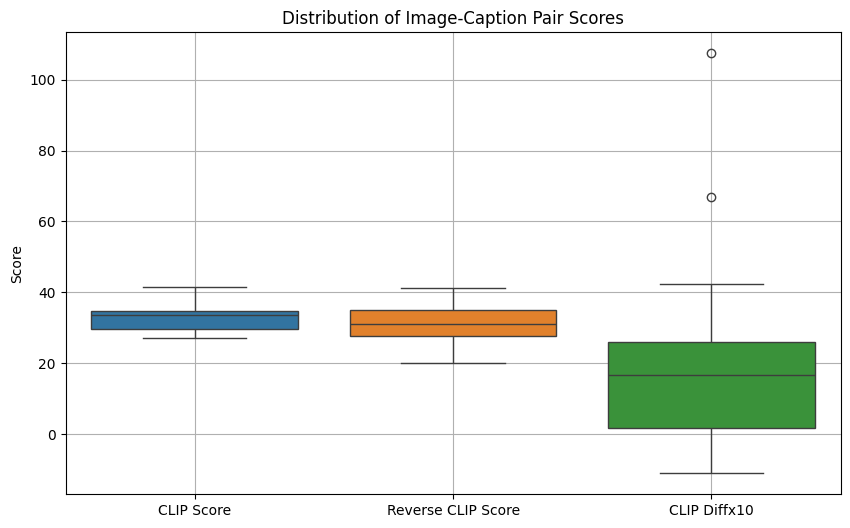

In [82]:
#base benchmark evalauation
evaluation(save_dir,json_file,metric ='clip')

In [15]:
#base benchmark evalauation (Using BLIP BARST)
evaluation(save_dir,json_file,metric ='blip', output_file_name = "blip_output")

Metric used is BLIP Score


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  


config.json:   0%|          | 0.00/7.68k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/133k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.44G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.33G [00:00<?, ?B/s]

ModuleNotFoundError: No module named 'transformers.models.deprecated.gptsan_japanese'

#Evaluation the base model usign winoground captions


This code use the original base model to generate images captions we considered as "interasting" from winoground
It saved in json file the image name, caption and reverse caption (generated fro caption using the function we used in the dataset filtering)

In [85]:

current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
winoground_captions_csv_file = f"{current_dir}/winoground_filtering_output.csv"
base_model_id  = "stabilityai/stable-diffusion-2-1-base"
captions_txt_none = "none"
base_winoground_dir = f'{current_dir}/base_evaluation_winoground'
base_winoground_json_file = evaluate_model(base_model_id, captions_txt_none, base_winoground_dir, winoground_captions_csv_file)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [64]:
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
base_winoground_dir = f'{current_dir}/base_evaluation_winoground'
base_winoground_json_file = f'{base_winoground_dir}/image_data.json'

In [86]:
torch.cuda.empty_cache()

Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_0.png, Caption: an old person kisses a young person, CLIP Score: 31.4453125, reverse caption a young person kisses an old person, reverse score 32.6171875, diff*10 -11.71875
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_1.png, Caption: the taller person hugs the shorter person, CLIP Score: 30.46875, reverse caption the shorter person hugs the taller person, reverse score 30.3466796875, diff*10 1.220703125
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/base_evaluation_winoground/image_2.png, Caption: the masked wrestler hits the unmasked wrestler, CLIP Score: 32.71484375, reverse caption the unmasked wrestler hits the masked wrestler, reverse score 32.51953125

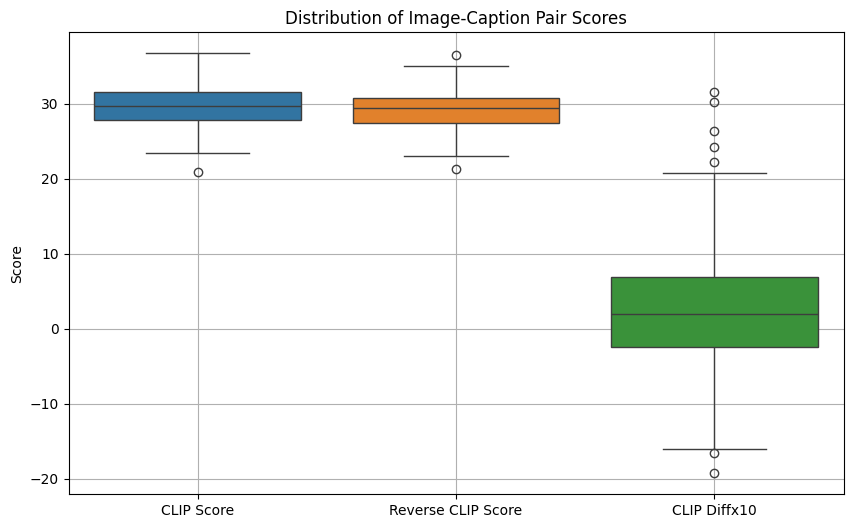

CLIP Score: Avrage:29.50098181283602 var: 8.797550603880028,  Reverse CLIP Score: avg:29.221270161290324 var:8.133211629571823,  CLIP Diff: avg:2.797116515456989 var: 90.35059710791626


In [87]:
#base winoground evalauation
evaluation(base_winoground_dir,base_winoground_json_file,metric ='clip')

#Evaluate our trained model using Benchmark list
This code use our trained model to generate images from our benchmark list It saved in json file the image name, caption and reverse caption (generated fro caption using the function we used in the dataset filtering)

In [1]:
torch.cuda.empty_cache()


NameError: name 'torch' is not defined

In [18]:
current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
model_id  = "nadavo11/ImSitu_actions_model"
captions_txt = f'{current_dir}/benchmark.txt'
trained_bm_dir = [None] * 4
caption_csv = "none"
for i in range(4):
  seed_base =41
  trained_bm_dir[i] = f'{current_dir}/bm_trained_evaluation_{i}'
  bm_trained_json = evaluate_model(model_id, captions_txt, trained_bm_dir[i], 'none',  seed = seed_base+i)


model_index.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/379 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/634 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/839 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.89k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-0f18a28d1ceb>", line 9, in <cell line: 6>
    bm_trained_json = evaluate_model(model_id, captions_txt, trained_bm_dir[i], 'none',  seed = seed_base+i)
  File "<ipython-input-13-1dbf6cbb1b9a>", line 40, in evaluate_model
    image = sd_model(caption, generator=generator).images[0]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 116, in decorate_context
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py", line 1020, in __call__
    latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
  File "/usr/local/lib/python3.10/dist-packages/diffusers/schedulers/scheduling_pndm.py", line 257, in step
    return

TypeError: object of type 'NoneType' has no len()

In [88]:
trained_bm_dir = f'{current_dir}/bm_trained_evaluation'
bm_trained_json = f'{trained_bm_dir}/image_data.json'

Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_evaluation/image_0.png, Caption: A dog giving a present to a man., CLIP Score: 31.3232421875, reverse caption A present givings a dog to a man., reverse score 28.759765625, diff*10 25.634765625
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_evaluation/image_1.png, Caption: A dolphin rescuing a swimmer., CLIP Score: 26.9775390625, reverse caption A swimmer rescuings a dolphin., reverse score 25.244140625, diff*10 17.333984375
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/bm_trained_evaluation/image_4.png, Caption: A rabbit bringing vegetables to a gardener., CLIP Score: 35.5224609375, reverse caption Vegetables bringings a rabbit to a gardener., reverse score 32.6904296875, diff*10 28.3203125
Metric use

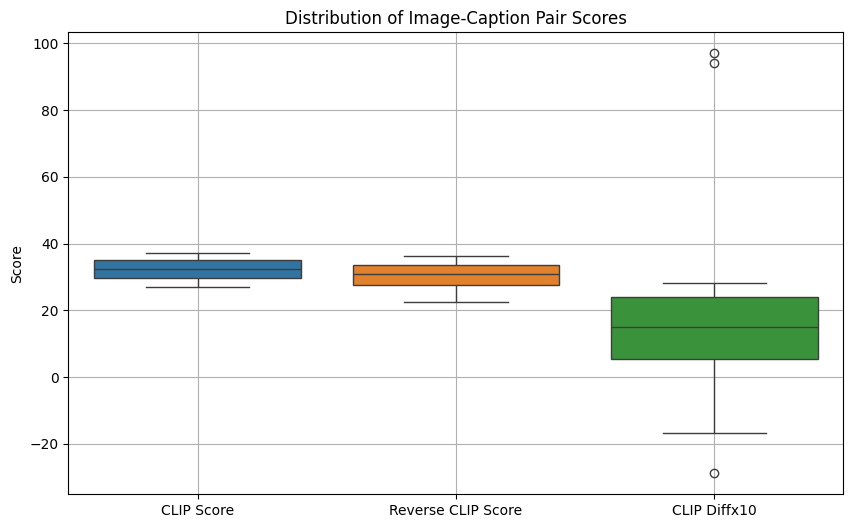

CLIP Score: Avrage:32.3830997242647 var: 10.333065343150633,  Reverse CLIP Score: avg:30.440027573529413 var:17.059759903944073,  CLIP Diff: avg:19.430721507352942 var: 1004.6314409447377


In [89]:
evaluation(trained_bm_dir,bm_trained_json,metric ='clip')

In [ ]:
evaluation(trained_bm_dir,bm_trained_json,metric ='blip', output_file_name = "blip_ouput")

#Evaluate trained model using winoground captions
This code use our trained model to generate images captions we considered as "interasting" from winoground
It saved in json file the image name, caption and reverse caption (generated fro caption using the function we used in the dataset filtering)

In [73]:

current_dir = f'/content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation'
winoground_captions_csv_file = f"{current_dir}/winoground_filtering_output.csv"
model_id  = "nadavo11/ImSitu_actions_model"
captions_txt_none = "none"
winoground_trained_dir = f'{current_dir}/trained_evaluation_winoground'
winoground_trained_json = evaluate_model(model_id, captions_txt_none, winoground_trained_dir, winoground_captions_csv_file)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Evaluating using cuda


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [90]:
winoground_trained_dir= f'{current_dir}/trained_evaluation_winoground'
winoground_trained_json = f'{winoground_trained_dir}/image_data.json'

Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/trained_evaluation_winoground/image_0.png, Caption: an old person kisses a young person, CLIP Score: 30.2490234375, reverse caption a young person kisses an old person, reverse score 31.15234375, diff*10 -9.033203125
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/trained_evaluation_winoground/image_1.png, Caption: the taller person hugs the shorter person, CLIP Score: 31.1767578125, reverse caption the shorter person hugs the taller person, reverse score 31.5673828125, diff*10 -3.90625
Metric used is CLIP Score using cuda
Image: /content/drive/MyDrive/MSC/summer_24/deep_learning/Final Project/evaluation/trained_evaluation_winoground/image_2.png, Caption: the masked wrestler hits the unmasked wrestler, CLIP Score: 27.63671875, reverse caption the unmasked wrestler hits the masked wrestler, reverse

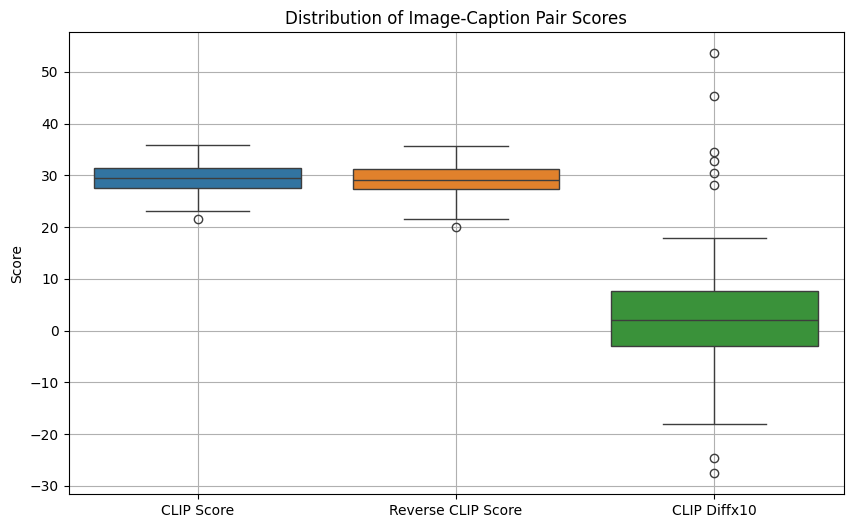

CLIP Score: Avrage:29.440209173387096 var: 8.366059562294094,  Reverse CLIP Score: avg:29.10379389280914 var:8.199256422175383,  CLIP Diff: avg:3.36415280577957 var: 147.7882626125862


In [91]:
evaluation(winoground_trained_dir,winoground_trained_json,metric ='clip')